In [1]:
# 这是一个初始化文件，用于导入常用的库和设置一些全局的参数
import matplotlib.colors as mcolors
import matplotlib.animation as ma
import matplotlib.pyplot as plt
from tqdm import tqdm
from itertools import product
import numpy as np
import numba as nb
import imageio
import os
import shutil
from main import *

randomSeed = 100

%matplotlib inline
%config InlineBackend.figure_format = "retina"

new_cmap = mcolors.LinearSegmentedColormap.from_list(
    "new", plt.cm.jet(np.linspace(0, 1, 256)) * 0.85, N=256
)

@nb.njit
def colors_idx(phaseTheta):
    return np.floor(256 - phaseTheta / (2 * np.pi) * 256).astype(np.int32)

import seaborn as sns

sns.set(font_scale=1.1, rc={
    'figure.figsize': (6, 5),
    'axes.facecolor': 'white',
    'figure.facecolor': 'white',
    'grid.color': '#dddddd',
    'grid.linewidth': 0.5,
    "lines.linewidth": 1.5,
    'text.color': '#000000',
    'figure.titleweight': "bold",
    'xtick.color': '#000000',
    'ytick.color': '#000000'
})

plt.rcParams['mathtext.fontset'] = 'stix'
plt.rcParams['font.family'] = 'STIXGeneral'
plt.rcParams['animation.ffmpeg_path'] = r"C:\Users\Aero Planck\AppData\Local\Programs\Python\Python312\ffmpeg\bin\ffmpeg.exe"

In [2]:
# 这里是一个模型的实例, strengthLambda是相互作用的强度(耦合强度)，distanceD0是相互作用的距离，可以调整不同的参数多跑跑看
model = SpatialGroups(strengthLambda=0.65, distanceD0=2.0, phaseLagAlpha=-np.pi / 2, tqdm=True, savePath="./data/", overWrite=True)

In [3]:
# 这里是模型的计算执行函数，输入的参数是模型的迭代次数(演化时间)
model.run(100)

  0%|          | 0/40000 [00:00<?, ?it/s]

In [4]:
# 这里是模型的可视化函数，用于生成动画，输入的参数是模型的实例，运行完毕后会在当文件夹mp4下生成一个mp4文件
# 注意这里的模型实例必须是已经执行过计算的(即已经run过，在data文件夹中有模型的数据文件)
draw_mp4(model)

  0%|          | 0/8002 [00:00<?, ?it/s]

./data/CorrectCoupling_uniform_0.650_2.00_-1.571_10.h5


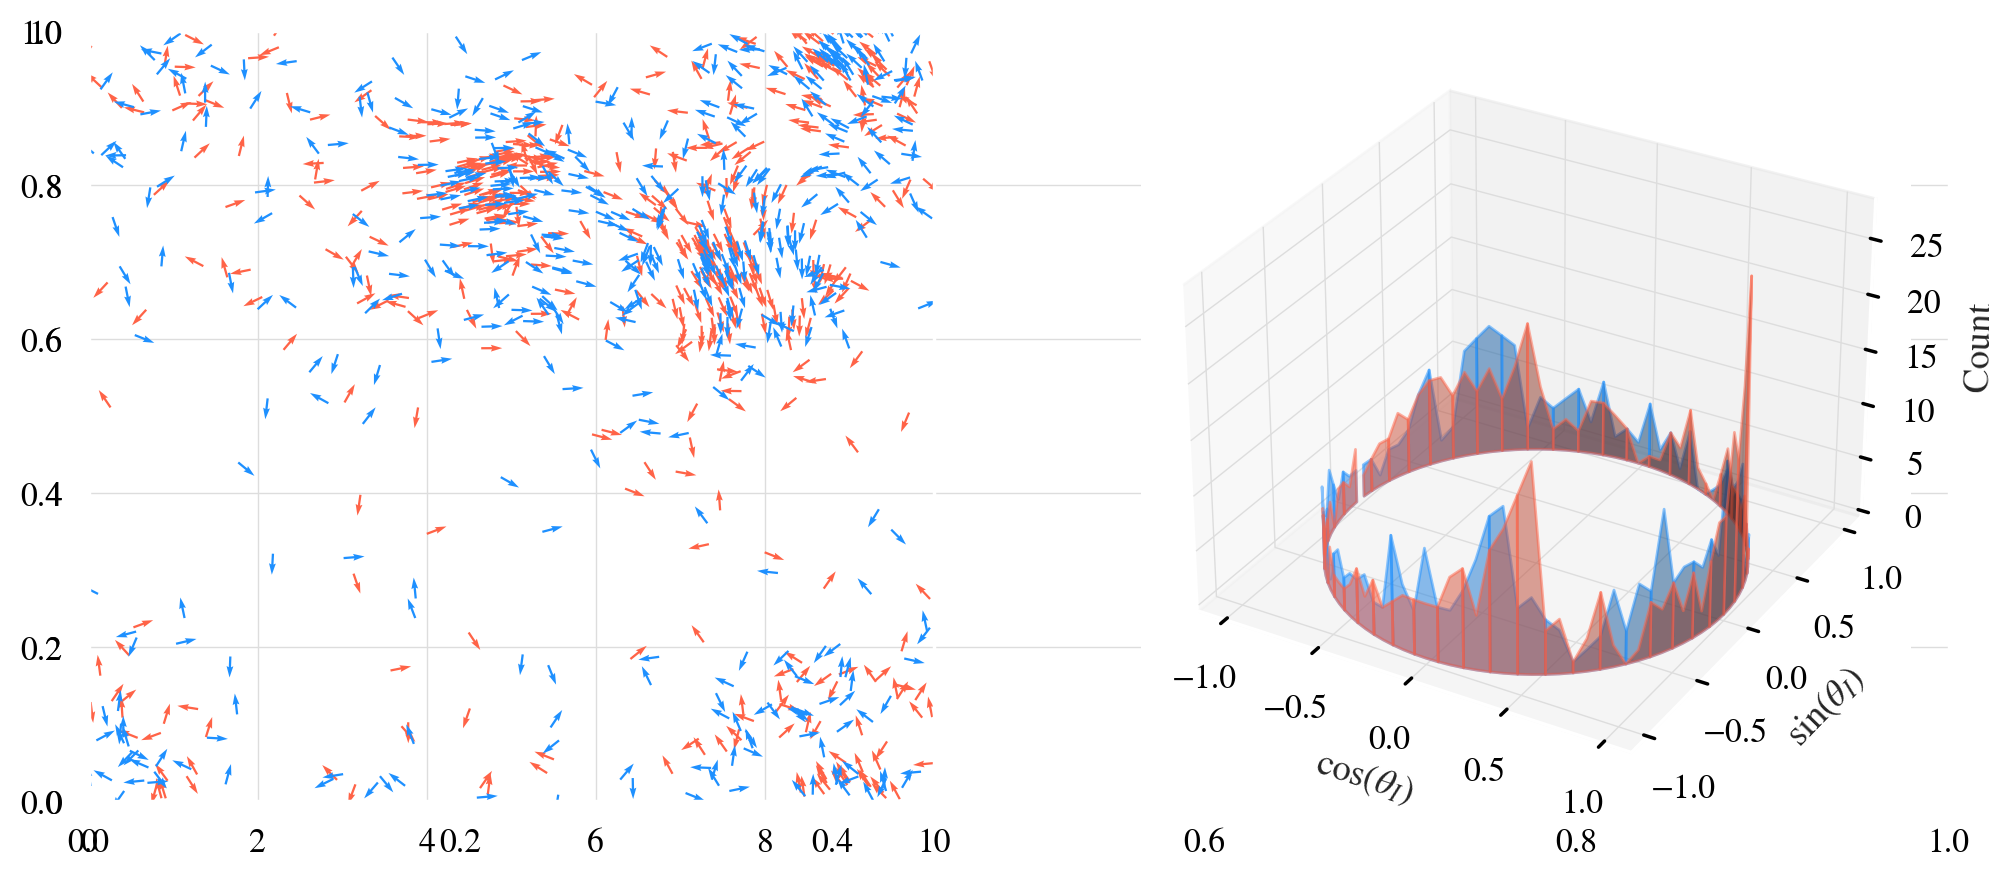

In [5]:
# 这里是模型的可视化函数，用于生成最后一帧的图像，输入的参数是模型的实例，运行完毕后会在下面显示最后一帧的图像
plot_last(model)

In [6]:
targetPath = f"./data/{model}.h5"
totalPositionX = pd.read_hdf(targetPath, key="positionX")
totalPhaseTheta = pd.read_hdf(targetPath, key="phaseTheta")
totalPointTheta = pd.read_hdf(targetPath, key="pointTheta")
TNum = totalPositionX.shape[0] // model.agentsNum
totalPositionX = totalPositionX.values.reshape(TNum, model.agentsNum, 2)
totalPhaseTheta = totalPhaseTheta.values.reshape(TNum, model.agentsNum)
totalPointTheta = totalPointTheta.values.reshape(TNum, model.agentsNum)

positionX = totalPositionX[-1, :, :]
phaseTheta = totalPhaseTheta[-1, :]
pointTheta = totalPointTheta[-1, :]

In [7]:
totalPositionX.shape  # (TNum, agentsNum, 2)

(8002, 1000, 2)

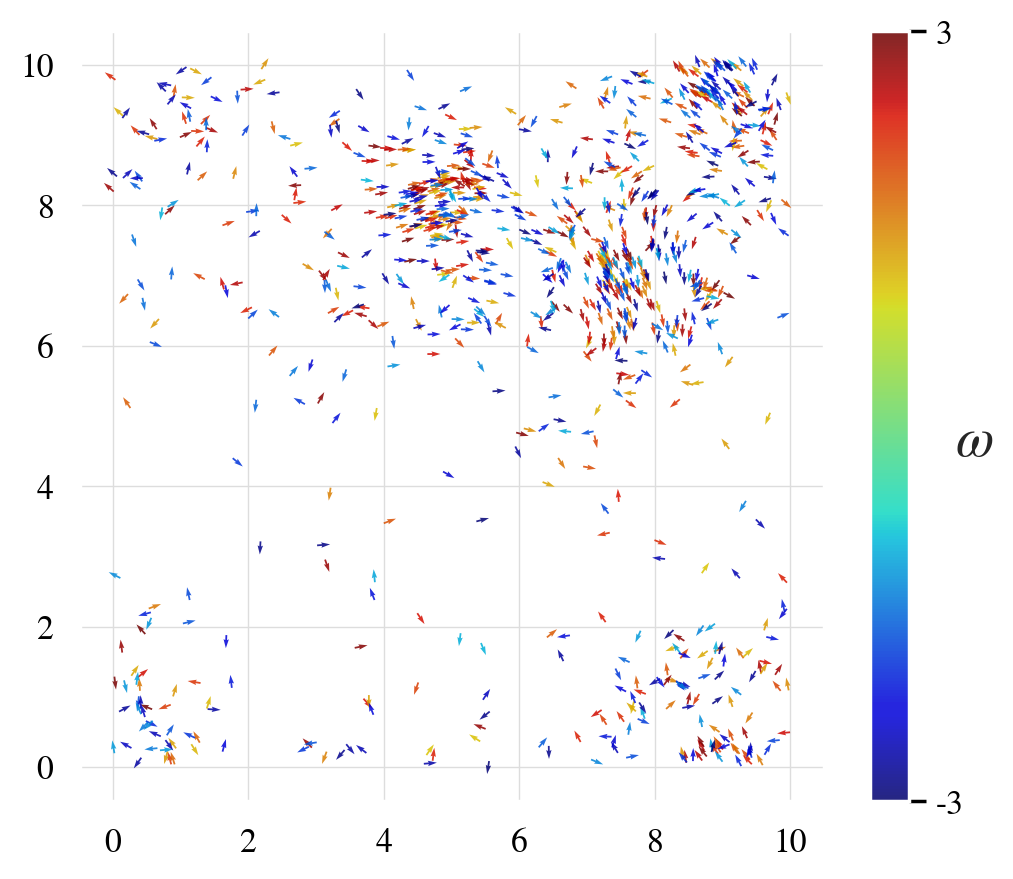

In [8]:
unitOmega = (model.omegaTheta + 3) / 6
ax = plt.subplot(1, 1, 1)
line = ax.quiver(
    positionX[:, 0],  # 振子横坐标 
    positionX[:, 1],  # 振子纵坐标
    np.cos(phaseTheta),  # 速度的横向分量 
    np.sin(phaseTheta),   # 速度的纵向分量
    color=new_cmap(unitOmega),  # 自然频率对应颜色
    cmap=new_cmap,  # 使用自定义的颜色映射
)
cbar = plt.colorbar(line, ax=ax, ticks=[0, 1])
cbar.ax.set_yticklabels(['-3', '3'])
cbar.set_label(r"$\omega$", fontsize=20, rotation=0)

$$
\begin{array}{c}
	X_i\left( t \right) =x_i\left( t \right) -\frac{v}{\dot{\theta}_i\left( t \right)}\sin \theta _i\left( t \right) \;,\\
	Y_i\left( t \right) =y_i\left( t \right) +\frac{v}{\dot{\theta}_i\left( t \right)}\cos \theta _i\left( t \right) \;,\\
\end{array}
$$

C:\Users\Aero Planck\AppData\Local\Temp\ipykernel_16932\4089918210.py:21: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(modCenters[:, 0], modCenters[:, 1], c=new_cmap(unitOmega), cmap=new_cmap, s=1)
C:\Users\Aero Planck\AppData\Local\Temp\ipykernel_16932\4089918210.py:25: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(np.abs(model.omegaTheta), radii, c=new_cmap(unitOmega), cmap=new_cmap, s=1)


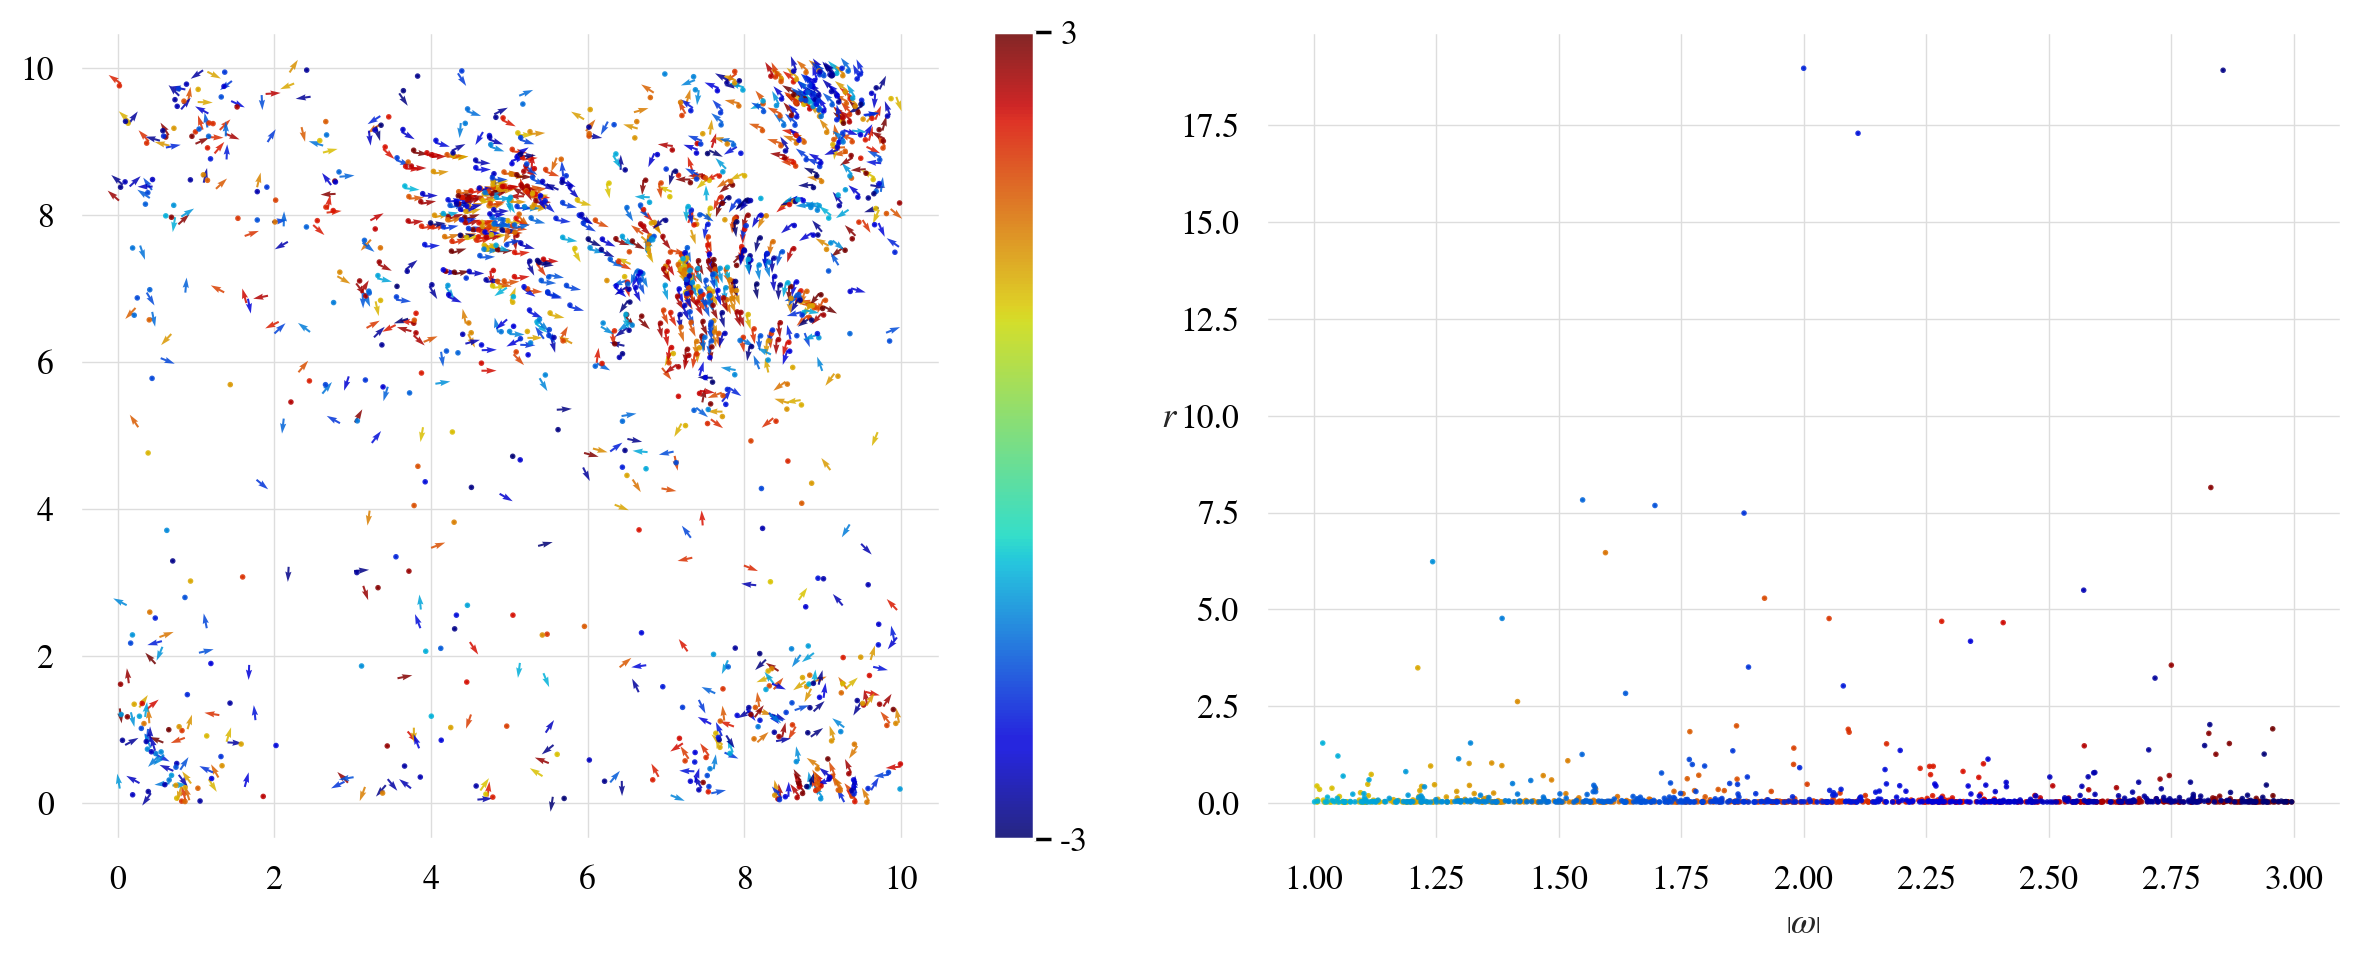

In [9]:
centers = np.array([
    positionX[:, 0] - model.speedV / pointTheta * np.sin(phaseTheta),
    positionX[:, 1] + model.speedV / pointTheta * np.cos(phaseTheta)
]).T
modCenters = np.mod(centers, model.boundaryLength)
plt.figure(figsize=(12, 5))
ax = plt.subplot(1, 2, 1)
line = ax.quiver(
    positionX[:, 0],  # 振子横坐标 
    positionX[:, 1],  # 振子纵坐标
    np.cos(phaseTheta),  # 速度的横向分量 
    np.sin(phaseTheta),   # 速度的纵向分量
    color=new_cmap(unitOmega),  # 自然频率对应颜色
    cmap=new_cmap,  # 使用自定义的颜色映射
)

cbar = plt.colorbar(line, ax=ax, ticks=[0, 1])
cbar.ax.set_yticklabels(['-3', '3'])
# cbar.set_label(r"$\omega$", fontsize=20, rotation=0)

ax.scatter(modCenters[:, 0], modCenters[:, 1], c=new_cmap(unitOmega), cmap=new_cmap, s=1)

ax = plt.subplot(1, 2, 2)
radii = np.sqrt(np.sum((positionX - centers) ** 2, axis=1))
ax.scatter(np.abs(model.omegaTheta), radii, c=new_cmap(unitOmega), cmap=new_cmap, s=1)
ax.set_xlabel(r"$\left| \omega \right|$")
ax.set_ylabel(r"$r$", rotation=0)
# ax.set_ylim(0, 6)

plt.tight_layout()

In [22]:
240 /